In [1]:
# This line solves some minor problems when you do not have propery set the PYTHONPATH
exec(compile(open("fix_paths.py", "rb").read(), "fix_paths.py", 'exec'))

## Load data example

In [2]:
from common import dataset_loaders
original_labels = dataset_loaders.groundlabels_dataframe()

map_category = {'A':'Moto', 'B':'Car', 'C':'Car', 'D':'Car', 'E':'Car', 'F':'Car', 'G':'Car', 'H':'Van', 'I':'Bus'}
glabels2 = dataset_loaders.map_labels(original_labels, map_category)

# Plot data example

In [22]:
#from common import plot_utils
#%matplotlib inline
#%pylab inline
#pylab.rcParams['figure.figsize'] = (15, 15)

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#casename = dataset_loaders.get_casenames()[0]
#img = dataset_loaders.load_image(casename)
#labels = glabels[glabels['image'] == casename]
#plot_utils.draw(img, labels)

In [ ]:
#casenames = dataset_loaders.get_casenames()[:10]
#imgs = [dataset_loaders.load_image(casename) for casename in casenames]
#labs = [glabels[glabels['image'] == casename] for casename in casenames]
#plot_utils.multidraw([5,4], imgs, labs)

# Example to use loaders

In [ ]:
casename = dataset_loaders.get_casenames()[0]
img = dataset_loaders.load_image(casename)
labels = glabels[glabels['image'] == casename]

# TRAIN PROCESS

## Load model

In [4]:
# This line solves some minor problems when you do not have propery set the PYTHONPATH
exec(compile(open("fix_paths.py", "rb").read(), "fix_paths.py", 'exec'))

import settings
import os
import pandas as pd
from common import dataset_loaders
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from patch_generators.pos_and_negative_fix_size import LabelEncoding, data_generator
import time

experiment_folder_name = 'patches_single_size'
experiment_name = 'vehicle_empty_resnet_v0'
OUTPUT_MODEL = '%s/%s/models/all_discriminator_remote.hdf5' % (settings.DATAMODEL_PATH, experiment_folder_name)
LOGS_PATH    = '%s/%s/logs/%s' % (settings.DATAMODEL_PATH, experiment_folder_name, experiment_name)

image_size_nn = 48
patch_size = 110


# We load the cases as they were originally...if needed
original_labels = dataset_loaders.groundlabels_dataframe()
## train_data = pd.read_csv('%s/%s/train_df.csv' % (settings.DATAMODEL_PATH, experiment_folder_name))
## valid_data = pd.read_csv('%s/%s/valid_df.csv' % (settings.DATAMODEL_PATH, experiment_folder_name))

# Initialize these cases
## We add background as label to the rest of existing labels
existing_labels = np.concatenate([original_labels['class'].unique(), ['background']])
labelencoder = LabelEncoding(existing_labels)


import logging
from sklearn import metrics
from keras import backend as K

K.set_image_dim_ordering('th')

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, History
from dl_utils.dl_networks.resnet import ResnetBuilder
from dl_utils.tb_callback import TensorBoard


model = ResnetBuilder().build_resnet_50((3,image_size_nn,image_size_nn),len(existing_labels))
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy')#,'fmeasure'])
model.load_weights(OUTPUT_MODEL)


/home/jose/tech/ml_projects/kaggle/cars_contest/dl_utils/dl_networks/resnet.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(7, 7), filters=64, strides=(2, 2), padding="same", kernel_initializer="he_normal", kernel_regularizer=<keras.reg...)`
  init=init, border_mode=border_mode, W_regularizer=W_regularizer)(input)
/home/jose/tech/ml_projects/kaggle/cars_contest/dl_utils/dl_networks/resnet.py:211: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")`
  pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), border_mode="same")(conv1)
/home/jose/tech/ml_projects/kaggle/cars_contest/dl_utils/dl_networks/resnet.py:147: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(1, 1), filters=64, strides=(1, 1), padding="same", kernel_initializer="he_normal", kernel_regularizer=<keras.reg...)`
  W_regularizer=l2(0.0001))(input)
/home/jose/tech/ml_projects/ka

In [5]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 3, 48, 48)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 64, 24, 24)    9472                                         
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 64, 24, 24)    256                                          
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 64, 24, 24)    0                                            
___________________________________________________________________________________________

## Load a sample case

In [114]:
casenames = dataset_loaders.get_casenames()
case = casenames[0]
car_x, car_y = original_labels[original_labels.image == case][['x','y']].values[0]

In [115]:
import time
t1 = time.time()

batch_size = 500
scan_step = 10
square_scan = [car_x-250, car_x+250, car_y-250, car_y+250]
#square_scan = None

## Basic scan patches

In [138]:
import numpy as np
import scipy.misc
from common import dataset_loaders

def scan_patches(imagename, image_size_nn, patch_size, step_frames, batch_size, square_to_scan = None):
    img = dataset_loaders.load_image(imagename)
    if square_to_scan is None:
        square_to_scan = [0,img.shape[0],0,img.shape[1]]
    # Ensure the patch does not go out of the image
    x_ini = np.max([square_to_scan[0], int(patch_size/2)])
    x_end = np.min([square_to_scan[1], int(img.shape[0]-patch_size/2)])
    y_ini = np.max([square_to_scan[2], int(patch_size/2)])
    y_end = np.min([square_to_scan[3], int(img.shape[1]-patch_size/2)])
    
    patches = []
    wnd = int(patch_size/2)
    for xi in range(x_ini, x_end, step_frames):
        for yi in range(y_ini, y_end, step_frames):
            patches.append(scipy.misc.imresize(img[xi-wnd:xi+wnd,yi-wnd:yi+wnd], [image_size_nn, image_size_nn]) / 255)
            if len(patches) == batch_size:
                yield np.array(patches).transpose([0,3,1,2])
                patches = []
    if len(patches) > 0:
        yield np.array(patches).transpose([0,3,1,2])

patches = scan_patches(case, image_size_nn, patch_size, scan_step, batch_size, square_to_scan = square_scan)

preds = []
for x in patches:
    preds.append(model.predict(x))
    print(len(preds))
preds = np.vstack(preds)
preds = preds.reshape([int(np.sqrt(preds.shape[0])),int(np.sqrt(preds.shape[0])), preds.shape[1]])

1
2
3
4
5


##  Show results

Populating the interactive namespace from numpy and matplotlib


/home/jose/tech/anaconda3/envs/kgcars/lib/python3.6/site-packages/matplotlib/colors.py:821: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/jose/tech/anaconda3/envs/kgcars/lib/python3.6/site-packages/numpy/ma/core.py:2766: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


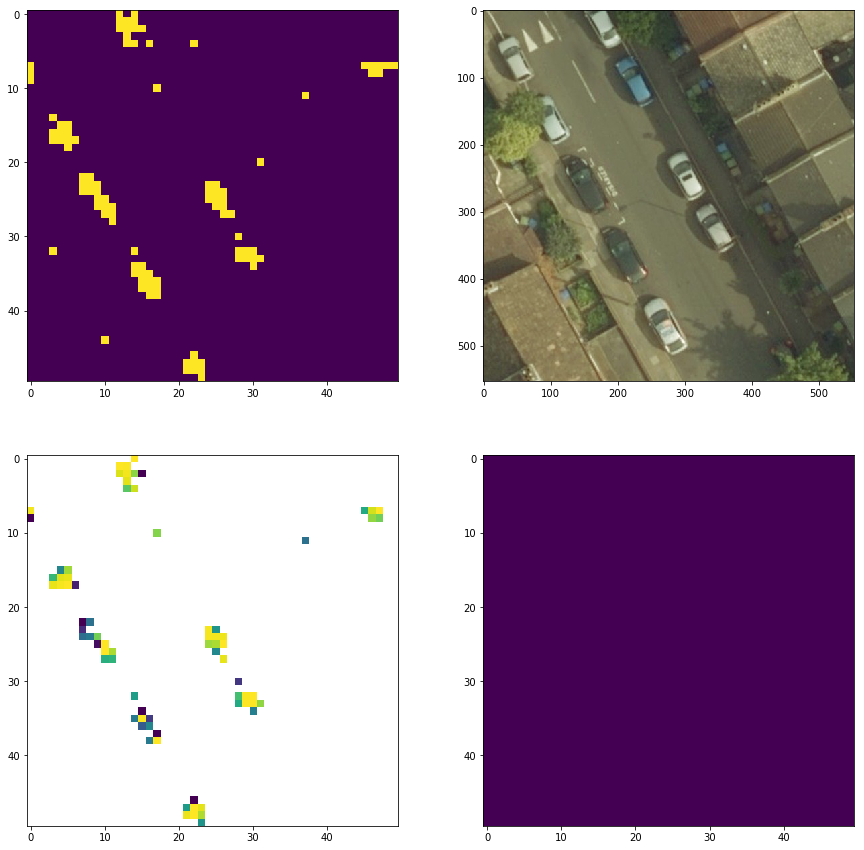

In [164]:
from common import plot_utils
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 15)

if square_scan is not None:
    img_patches = dataset_loaders.load_image(case)[square_scan[0]:square_scan[2], square_scan[1]:square_scan[3]]
else:
    img_patches = dataset_loaders.load_image(case)

figure()
subplot(131)
imshow(preds[:,:,:9].sum(axis=2) >= 0.85, alpha = 1) # Probability de que haya algun vehiculo
subplot(132)
imshow(img_patches)
subplot(133)
for i in range(9):
    aux = np.copy(preds[:,:,i])
    aux[aux <= 0.85] = numpy.nan
    imshow(aux)
    
## Per case
subplot(224)
aux = preds.argmax(axis=2)
for i in range(9):    
    aux2 = np.copy(aux==i)
    aux2[aux2 == False] = numpy.nan
    imshow(aux2)
